In [1]:
import pandas as pd

df = pd.read_csv('train-data.dat', sep=',', header=None)
df.columns = ['sentence']
df['sentence'] = df['sentence'].str.replace('<.*?>', '', regex=True)  # deletes <int>
# print(df.head())
df = df[0:1000]
df.head()

vocab = pd.read_csv('vocabs.txt', sep=',', header=None)
vocab.columns = ['word', 'id']

sentences = pd.read_csv('train-data.dat', sep=',', header=None)
sentences.head()

com = []
for line in df.sentence:
    sen = ''
    for word in line.split():
      for id in vocab.id:
        if int(word) == int(id):
          sen = sen + ' ' + str(vocab.word[id]) 
    # print(sen)
    com.append(sen)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_vectors = tfidf_vectorizer.fit_transform(com)

tfidf = tfidf_vectors.todense()
# TFIDF of words not in the doc will be 0, so replace them with nan
tfidf[tfidf == 0] = np.nan
# Use nanmean of numpy which will ignore nan while calculating the mean
means = np.nanmean(tfidf, axis=0)
# convert it into a dictionary for later lookup
means = dict(zip(tfidf_vectorizer.get_feature_names(), means.tolist()[0]))

tfidf = tfidf_vectors.todense()
# Argsort the full TFIDF dense vector
ordered = np.argsort(tfidf*-1)
words = tfidf_vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [3]:
li = [[]]

for key in means:
  li.append([key, means[key]])

li.pop(0)
li[:5]

df2 = pd.DataFrame(li)
# df2 = df2.transpose()
df2.head()

tfidf_sc = df2[1]
print(tfidf_sc)

tfidf_len = len(tfidf_sc)
print(tfidf_len)

0       0.180064
1       0.105520
2       0.098096
3       0.163385
4       0.138688
          ...   
6848    0.110620
6849    0.151121
6850    0.124428
6851    0.184492
6852    0.223934
Name: 1, Length: 6853, dtype: float64
6853


In [4]:
# !pip install deap
import importlib.util

package_name = 'deap'

spec = importlib.util.find_spec(package_name)
if spec is None:
  !pip install deap
else:
  pass

import random
import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools

POP_SIZE = 20
# P_CROSSOVER = 0.6
# P_MUTATION = 0.01
MAX_GENERATIONS = 10
GENERATIONS_EXIT = 3  # state the number of generations in which maxFitness remains the same,  for stopping condition


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 160 kB 5.2 MB/s 


In [5]:
# tfidf_sc
df2.columns=['word', 'importance']
# print(df2.head(5))

def evaluation_function(individual):  

  sum = 0
  a = 0
  for i in individual:
    if i==1:
      a += df2.importance[i]
      sum += 1
  # a = a/sum

  counter = 0
  for i in individual:
    if i==1:
      counter+=1
  if counter<1000:
    a -= 50
  else:
    pass
  
  # a = a * 10000000000 - 10552039112682

  return a, 

In [6]:
tbx = base.Toolbox()

INDIVIDUAL_SIZE = tfidf_len

tbx.register("attr_bool", random.randint, 0, 1)
tbx.register('individual', tools.initRepeat, creator.Individual, tbx.attr_bool, INDIVIDUAL_SIZE)
tbx.register("population", tools.initRepeat, list, tbx.individual)

tbx.register("evaluate", evaluation_function)
tbx.register("select", tools.selTournament, tournsize=3)
tbx.register("mate", tools.cxUniform, indpb=0.5)
# tbx.register("mutate", tools.mutFlipBit, indpb=0.05)
tbx.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.8)

In [94]:
def main():

  maxFitValues = []
  maxGenValues = []
  best_indx = []
  best = {}

  for i in range(10):
    print('Iteration {} --->'.format(i))
    pop = tbx.population(POP_SIZE)

    fitnesses = list(map(tbx.evaluate, pop))

    maxFitnessValues = []
    meanFitnessValues = []
    genbest = {}

    for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit

    CXPB, MUTPB = 0.5, 0.2

    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0

    # Begin the evolution
    while g < MAX_GENERATIONS:
      #Stopping Conditions
      if g > GENERATIONS_EXIT and (
                    all(v == maxFitnessValues[len(maxFitnessValues) - 1] for v in maxFitnessValues[
                                                                                  (len(maxFitnessValues) - GENERATIONS_EXIT):len(maxFitnessValues)])):
        print("Stopping Conditions Occured.")
        break
      
      g = g + 1
      # print("-- Generation %i --" % g)

      # Select the next generation individuals
      offspring = tbx.select(pop, len(pop))
      # Clone the selected individuals
      offspring = list(map(tbx.clone, offspring))

      # Apply crossover and mutation on the offspring
      for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
          tbx.mate(child1, child2)
          del child1.fitness.values
          del child2.fitness.values

      for mutant in offspring:
        #Elitism - Elitist individuals do not get mutated
        if mutant != tools.selBest(offspring, 3, fit_attr="fitness"):
          if random.random() < MUTPB:
            tbx.mutate(mutant)
            del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = map(tbx.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

      #Replace the old population with the offspring
      pop[:] = offspring

      fitnessValues = [ind.fitness.values[0] for ind in pop]
      
      maxFitness = int(max(fitnessValues))
      meanFitness = int(sum(fitnessValues) / len(pop))
      maxFitnessValues.append(maxFitness)
      meanFitnessValues.append(meanFitness)
      print("- Generation {}: Max Fitness = {}, Avg Fitness = {}"
                  .format(g, maxFitness, meanFitness))
      
      best_index = fitnessValues.index(max(fitnessValues))

      # print(maxFitness, pop[best_index])
      genbest[maxFitness] = pop[best_index]

    maxGenValues.append(g)
    maxFitValues.append(max(maxFitnessValues))
    
    best.update(genbest)
   

  best = sorted(best.items())
  alpha = list(best)[-1]
  # print('Alpha Individual: ', alpha[1])


  print("Average Fitness of best individual is:", np.mean(maxFitValues))
  print("Best Fitness of best individual is:", np.amax(max(maxFitValues)))
  print("Average generation when stopping conditions are met:", np.mean(maxGenValues))
  plt.figure(0)
  plt.plot(maxFitnessValues, color='red')
  plt.plot(meanFitnessValues, color='green')
  plt.xlabel('Generation')
  plt.ylabel('Max / Average Fitness')
  plt.title('Max and Average fitness over Generations')
  plt.show()

  brain(alpha)

In [95]:
def brain(alpha):
  print(alpha[1])

  

Iteration 0 --->
- Generation 1: Max Fitness = 368, Avg Fitness = 364
- Generation 2: Max Fitness = 368, Avg Fitness = 365
- Generation 3: Max Fitness = 373, Avg Fitness = 366
- Generation 4: Max Fitness = 373, Avg Fitness = 367
- Generation 5: Max Fitness = 373, Avg Fitness = 368
Stopping Conditions Occured.
Iteration 1 --->
- Generation 1: Max Fitness = 373, Avg Fitness = 366
- Generation 2: Max Fitness = 373, Avg Fitness = 367
- Generation 3: Max Fitness = 376, Avg Fitness = 371
- Generation 4: Max Fitness = 376, Avg Fitness = 371
- Generation 5: Max Fitness = 379, Avg Fitness = 372
- Generation 6: Max Fitness = 382, Avg Fitness = 373
- Generation 7: Max Fitness = 382, Avg Fitness = 373
- Generation 8: Max Fitness = 382, Avg Fitness = 374
Stopping Conditions Occured.
Iteration 2 --->
- Generation 1: Max Fitness = 372, Avg Fitness = 363
- Generation 2: Max Fitness = 370, Avg Fitness = 366
- Generation 3: Max Fitness = 371, Avg Fitness = 368
- Generation 4: Max Fitness = 378, Avg Fitn

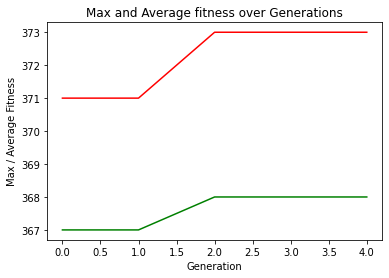

[1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 

In [96]:
main()